## Clustering SCADA data analysis- Evaluating different algorithms

In [2]:
# Import relevant libraries
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import MaxNLocator
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scada_data_analysis.modules.power_curve_preprocessing import PowerCurveFiltering

In [3]:
# Load data
df_scada = pd.read_csv('wtbdata_245days.csv.zip')
df_loc = pd.read_csv('sdwpf_baidukddcup2022_turb_location.csv')

### Data Exploration

##### Explore turbine scada data

In [4]:
df_scada.head()

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36


In [5]:
df_scada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727520 entries, 0 to 4727519
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 468.9+ MB


In [6]:
df_scada.describe()

,TurbID,Day,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
count,4.727520e+06,4.727520e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06,4.678002e+06
mean,6.750000e+01,1.230000e+02,5.028376e+00,4.975428e-01,4.110668e+01,2.739717e+01,1.885826e+02,2.685400e+01,2.683916e+01,2.682679e+01,-1.323900e+01,3.504458e+02
std,3.868139e+01,7.072483e+01,3.393703e+00,3.160275e+01,8.529011e+01,1.832832e+01,1.632459e+02,3.883566e+01,3.882940e+01,3.882235e+01,7.044244e+01,4.249932e+02
min,1.000000e+00,1.000000e+00,0.000000e+00,-3.030460e+03,-2.730300e+02,-2.731700e+02,-8.848600e+02,-1.000000e+01,-1.000000e+01,-1.000000e+01,-6.249800e+02,-9.330000e+00
25%,3.400000e+01,6.200000e+01,2.240000e+00,-3.830000e+00,1.405000e+01,2.006000e+01,6.302000e+01,1.000000e-02,1.000000e-02,1.000000e-02,-3.861000e+01,-3.000000e-01
50%,6.750000e+01,1.230000e+02,4.340000e+00,-2.300000e-01,2.573000e+01,3.008000e+01,1.947900e+02,5.400000e-01,5.400000e-01,5.400000e-01,-3.000000e-01,1.790800e+02
75%,1.010000e+02,1.840000e+02,7.010000e+00,3.420000e+00,3.273000e+01,3.682000e+01,3.219600e+02,8.399000e+01,8.398000e+01,8.398000e+01,-3.000000e-02,5.476600e+02
max,1.340000e+02,2.450000e+02,2.629000e+01,2.266950e+03,3.943300e+02,3.242100e+02,7.006200e+02,9.998000e+01,9.998000e+01,9.998000e+01,4.852000e+02,1.567020e+03


In [7]:
# Identify number of unique turbines in data
df_scada['TurbID'].nunique()

134

##### Explore location data

In [8]:
df_loc.head()

,TurbID,x,y
0,1,3349.8515,5939.23193
1,2,3351.0017,6416.64673
2,3,3314.7797,6892.18395
3,4,3352.0940,7366.14203
4,5,3355.3420,7841.20175


In [9]:
df_loc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TurbID  134 non-null    int64  
 1   x       134 non-null    float64
 2   y       134 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.3 KB


In [10]:
df_scada.shape

(4727520, 13)

### Data Preprocessing

In [11]:
df_scada.columns

Index(['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir',
       'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv'],
      dtype='object')

##### Extract desired features

In [12]:
dff_scada = df_scada[['TurbID',  'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Ndir', 'Patv']]

In [13]:
dff_scada.shape

(4727520, 7)

In [14]:
dff_scada.TurbID.nunique()

134

In [15]:
dff_scada.Day.nunique()

245

##### Data Cleaning

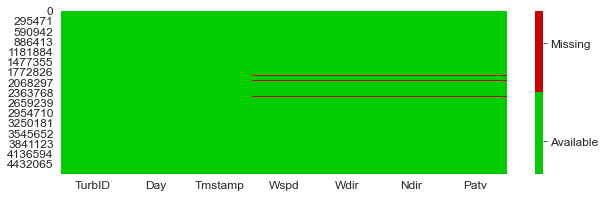

In [16]:
# Investigate missing values
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap

myColors = ((0.0, 0.8, 0.0, 1.0), (0.8, 0.0, 0.0, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

# Plot heatmap
plt.figure(figsize=(10, 3))
sns.set_style(style='white')
ax = sns.heatmap(dff_scada.isna().astype(int)+1, cmap=cmap);

# Post-process visualization
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([1.2, 1.8])
colorbar.set_ticklabels(['Available', 'Missing'], fontsize=12)

In [17]:
# Remove rows missing values
original_length = dff_scada.shape[0]
dff_scada = dff_scada.dropna()
dff_scada.reset_index(drop=True)
print(f'{round((original_length-dff_scada.shape[0])/original_length*100, 2)}% of original rows were removed')

1.05% of original rows were removed


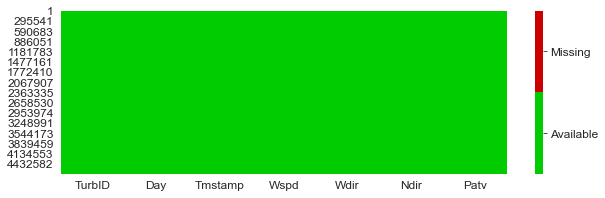

In [18]:
myColors = ((0.0, 0.8, 0.0, 1.0), (0.8, 0.0, 0.0, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

plt.figure(figsize=(10,3))
ax = sns.heatmap(dff_scada.isna().astype(int)+1, cmap=cmap, rasterized=True);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.95, 1.05])
colorbar.set_ticklabels(['Available', 'Missing'], fontsize=12)

##### Process time features

In [19]:
%%time
dff_scada['date_time'] = dff_scada[['Day', 'Tmstamp']].apply(lambda x: str(x[0]) + 'T' +str(x[1]), axis=1)

CPU times: total: 1min 14s
Wall time: 1min 15s


In [20]:
dff_scada['date_time'].nunique()

35016

##### Assign turbines to columns based on x location data

In [21]:
df_loc['x_round'] = df_loc['x'].round(-3)

In [22]:
df_loc['col_num'] = df_loc['x_round'].apply(lambda xx: 'c_0' if xx == 0 else 'c_1' if xx == 1000 else 'c_2' if xx == 2000 else 'c_3' if xx == 3000 else 'c_4' if xx == 4000 else 'c_5')

##### Data Filtering

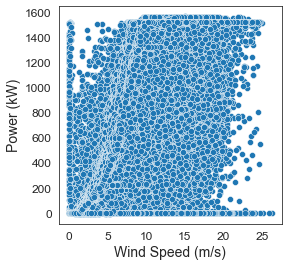

In [23]:
# Visualize raw power curve data
plt.figure(figsize=(4,4))
sns.scatterplot(x='Wspd', y='Patv', data=dff_scada);
plt.xlabel('Wind Speed (m/s)', fontsize=14)
plt.ylabel('Power (kW)', fontsize=14);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [24]:
cut_in_speed = 2.85

In [25]:
%%time
# Remove obvious abnormal points from data
ab_ind = dff_scada[(dff_scada['Wspd'] < cut_in_speed) & (dff_scada['Patv'] > 100)].index

CPU times: total: 234 ms
Wall time: 228 ms


In [26]:
norm_ind = list(set(dff_scada.index).difference(set(ab_ind)))

In [27]:
assert len(dff_scada) == len(norm_ind) + len(ab_ind)

In [28]:
scada_data = dff_scada.loc[norm_ind, :]

In [29]:
scada_data.shape

(4650478, 8)

##### Employ power curve filter to remove non-obvious abnormal points

In [30]:
pc_filter = PowerCurveFiltering(turbine_label='TurbID', windspeed_label='Wspd',
                                power_label='Patv', data=scada_data, cut_in_speed=cut_in_speed, bin_interval=0.5,
                                z_coeff=1.5, filter_cycle=15, return_fig=False)

In [31]:
%%time
cleaned_scada_df, _ = pc_filter.process()

CPU times: total: 3min 28s
Wall time: 3min 30s


In [32]:
cleaned_scada_df.shape

(1899031, 8)

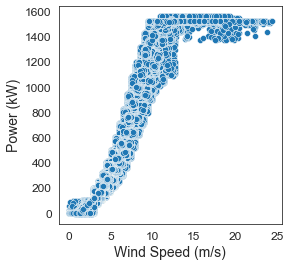

In [33]:
# Visualize cleaned power data

plt.figure(figsize=(4,4))
sns.scatterplot(x='Wspd', y='Patv', data=cleaned_scada_df);
plt.xlabel('Wind Speed (m/s)', fontsize=14)
plt.ylabel('Power (kW)', fontsize=14);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

##### Map turbine column locations to clean scada data

In [34]:
cleaned_scada_df['col_num'] = cleaned_scada_df['TurbID'].replace(df_loc.set_index('TurbID')['col_num']).values

##### Create test data for representativeness evaluation

In [35]:
# Create test data from cleaned SCADA data
df_cleaned_scada_test = cleaned_scada_df.sample(frac=0.0105, random_state=32)
train_ind = list(set(cleaned_scada_df.index).difference(set(df_cleaned_scada_test.index)))
cleaned_scada_data = cleaned_scada_df.loc[train_ind, :]
print('The test data contains', f'{df_cleaned_scada_test.shape[0]} rows', 'which is', 
      f'{round((df_cleaned_scada_test.shape[0]/cleaned_scada_df.shape[0])*100,2)}% of the cleaned dataset')

The test data contains 19940 rows which is 1.05% of the cleaned dataset


In [36]:
df_cleaned_scada_test = df_cleaned_scada_test.reset_index(drop=True)

##### Training data transformation

In [37]:
%%time
X_ws_df = pd.pivot_table(cleaned_scada_data, values='Wspd', index=['TurbID'], columns=['date_time'], aggfunc=np.mean)

CPU times: total: 1.08 s
Wall time: 1.09 s


In [38]:
X_ws_df.dropna(axis=1, inplace=True)

In [39]:
# Transformed windspeed data
X_ws_df

date_time,100T08:20,100T09:40,100T10:10,100T10:40,103T08:00,103T17:40,103T22:40,103T22:50,104T00:20,104T00:30,...,99T06:00,9T00:20,9T00:30,9T00:50,9T09:40,9T10:00,9T10:20,9T10:50,9T11:00,9T11:10
TurbID,,,,,,,,,,,,,,,,,,,,,
1,1.19,1.24,0.94,1.02,0.83,1.26,1.29,1.30,0.66,0.85,...,1.74,0.81,0.67,0.17,0.98,0.74,1.03,1.17,1.09,1.30
2,1.38,1.32,1.08,0.71,0.61,1.20,1.21,1.24,0.61,0.75,...,1.57,0.97,0.80,0.30,1.24,0.82,1.17,1.35,1.54,1.29
3,1.55,1.15,1.02,0.58,1.82,1.24,1.05,0.90,0.96,0.82,...,1.21,0.89,0.62,0.64,1.01,1.32,1.49,1.43,1.02,1.60
4,1.21,1.18,1.21,0.78,0.53,1.14,1.20,1.15,0.46,1.00,...,1.46,1.22,1.01,0.36,1.15,0.71,1.11,1.39,1.55,1.84
5,1.23,1.25,1.20,0.75,0.38,1.00,1.06,1.00,0.52,0.85,...,1.35,1.14,0.95,0.38,1.11,0.83,1.16,0.98,1.40,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,1.47,1.22,1.07,0.56,1.27,0.50,1.01,1.16,1.52,1.60,...,1.45,1.06,0.95,0.91,0.64,0.84,0.77,1.62,1.56,1.81
131,1.62,1.65,0.90,0.97,1.25,0.41,1.11,1.04,1.59,0.99,...,2.20,1.00,0.93,0.90,0.60,0.55,0.63,1.80,1.63,1.89
132,1.31,0.94,1.15,0.51,1.72,0.59,1.29,1.17,1.56,1.42,...,1.11,0.92,1.03,0.87,0.55,0.68,0.86,1.66,1.97,1.53


##### Training data scaling

In [40]:
scale = StandardScaler()
X_ws_df_sc = scale.fit_transform(X_ws_df)

In [41]:
X_ws_df_sc.shape

(134, 850)

### Cluster Modeling

#### KMeans

##### Silhouette method to determine optimal number of clusters

In [42]:
%%time
sil_ws =[]
for i in range(4, 25):
    KMS_WS = KMeans(n_clusters = i, random_state=32)
    KMS_WS.fit(X_ws_df_sc)
    # calculates the squared error for clustered points
    sil_ws.append(silhouette_score(X_ws_df_sc, KMS_WS.labels_))

CPU times: total: 3.09 s
Wall time: 3.11 s


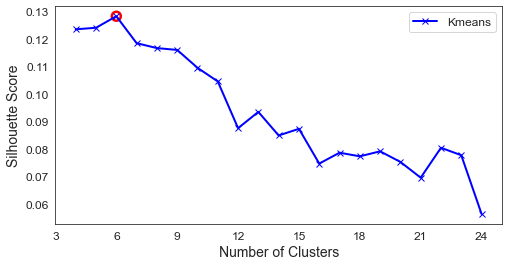

In [43]:
ax = plt.figure(figsize=(8,4)).gca()
plt.plot(range(4, 25), sil_ws, 'bx-', linewidth ='2', label='Kmeans')
plt.scatter(x=6, y=max(sil_ws), marker='o', s=80, edgecolors='r', facecolors='none', linewidths=2.5)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.legend(fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

##### Turbine clustering using optimal number of clusters

In [44]:
KMS_WS = KMeans(n_clusters = 6, random_state=32)

In [45]:
%%time
KMS_WS.fit(X_ws_df_sc)

CPU times: total: 141 ms
Wall time: 138 ms


KMeans(n_clusters=6, random_state=32)

In [46]:
X_ws_dff = X_ws_df.reset_index()

In [47]:
X_ws_dff['cluster_ws_kmeans'] = KMS_WS.predict(X_ws_df_sc)

In [48]:
%%time
cleaned_scada_data['cluster_ws_kmeans'] = cleaned_scada_data['TurbID'].replace(X_ws_dff.set_index('TurbID')['cluster_ws_kmeans']).values

CPU times: total: 969 ms
Wall time: 970 ms


#### Agglomerative clustering

##### Silhouette method

In [49]:
%%time
sil_ws_agc =[]
for i in range(6, 23):
    AGC_WS = AgglomerativeClustering(n_clusters = i)
    AGC_WS.fit(X_ws_df_sc)
    # calculates the squared error for clustered points
    sil_ws_agc.append(silhouette_score(X_ws_df_sc, AGC_WS.labels_))

CPU times: total: 109 ms
Wall time: 111 ms


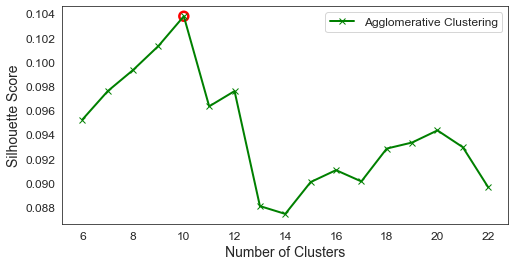

In [50]:
ax = plt.figure(figsize=(8,4)).gca()
plt.plot(range(6, 23), sil_ws_agc, 'gx-', linewidth ='2', label='Agglomerative Clustering')
plt.scatter(x=10, y=max(sil_ws_agc), marker='o', s=80, edgecolors='r', facecolors='none', linewidths=2.5)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.legend(fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

##### Turbine clustering using optimal number of clusters

In [51]:
AGC_WS = AgglomerativeClustering(n_clusters = 10)

In [52]:
X_ws_dff['cluster_ws_agc'] = AGC_WS.fit_predict(X_ws_df_sc)

In [53]:
%%time
cleaned_scada_data['cluster_ws_agc'] = cleaned_scada_data['TurbID'].replace(X_ws_dff.set_index('TurbID')['cluster_ws_agc']).values

CPU times: total: 969 ms
Wall time: 963 ms


#### GMM

In [54]:
%%time
sil_ws_gmm =[]
for i in range(7, 26):
    GMM_WS = GaussianMixture(n_components=i, random_state=32)
    # calculates the squared error for clustered points
    sil_ws_gmm.append(silhouette_score(X_ws_df_sc, GMM_WS.fit_predict(X_ws_df_sc)))

CPU times: total: 45.3 s
Wall time: 45.4 s


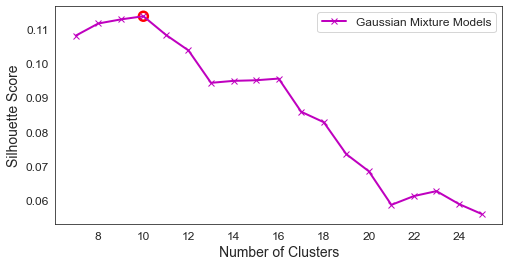

In [55]:
ax = plt.figure(figsize=(8,4)).gca()
plt.plot(range(7, 26), sil_ws_gmm, 'mx-', linewidth ='2', label='Gaussian Mixture Models')
plt.scatter(x=10, y=max(sil_ws_gmm), marker='o', s=80, edgecolors='r', facecolors='none', linewidths=2.5)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.legend(fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

##### Turbine clustering using optimal number of clusters

In [56]:
GMM_WS = GaussianMixture(n_components=10, random_state=32)

In [57]:
X_ws_dff['cluster_ws_gmm'] = GMM_WS.fit_predict(X_ws_df_sc)

In [58]:
%%time
cleaned_scada_data['cluster_ws_gmm'] = cleaned_scada_data['TurbID'].replace(X_ws_dff.set_index('TurbID')['cluster_ws_gmm']).values

CPU times: total: 1 s
Wall time: 994 ms


#### Affinity Propagation

In [59]:
%%time
sil_ws_ap =[]
d = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in d:
    AP_WS = AffinityPropagation(damping=i, random_state=32)
    # calculates the squared error for clustered points
    sil_ws_ap.append(silhouette_score(X_ws_df_sc, AP_WS.fit_predict(X_ws_df_sc)))

CPU times: total: 172 ms
Wall time: 172 ms


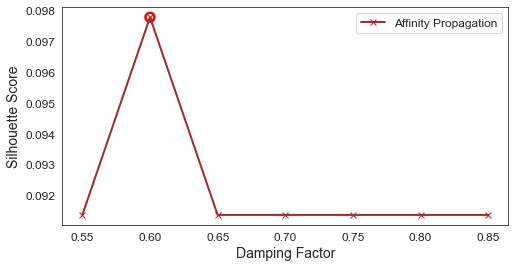

In [60]:
ax = plt.figure(figsize=(8,4)).gca()
plt.plot(d, sil_ws_ap, 'x-', color='brown', linewidth ='2', label='Affinity Propagation')
plt.scatter(x=0.6, y=max(sil_ws_ap), marker='o', s=80, edgecolors='r', facecolors='none', linewidths=2.5)
plt.xlabel("Damping Factor", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

##### Turbine clustering using optimal number of clusters

In [61]:
AP_WS = AffinityPropagation(damping=0.6, random_state=32)

In [63]:
X_ws_dff['cluster_ws_ap'] = AP_WS.fit_predict(X_ws_df_sc)

In [64]:
X_ws_dff['cluster_ws_ap'].unique()

array([ 1,  6,  2,  0,  3,  4,  5, 10,  8,  7,  9, 11, 12], dtype=int64)

In [65]:
%%time
cleaned_scada_data['cluster_ws_ap'] = cleaned_scada_data['TurbID'].replace(X_ws_dff.set_index('TurbID')['cluster_ws_ap']).values

CPU times: total: 906 ms
Wall time: 901 ms


### Results

##### Add cluster results to location data

In [66]:
df_loc_clusters = df_loc.copy()

In [67]:
df_loc_clusters['cluster_ws_kmeans'] = X_ws_dff['cluster_ws_kmeans']
df_loc_clusters['cluster_ws_agc'] = X_ws_dff['cluster_ws_agc']
df_loc_clusters['cluster_ws_gmm'] = X_ws_dff['cluster_ws_gmm']
df_loc_clusters['cluster_ws_ap'] = X_ws_dff['cluster_ws_ap']

#### Visualize clusters with location

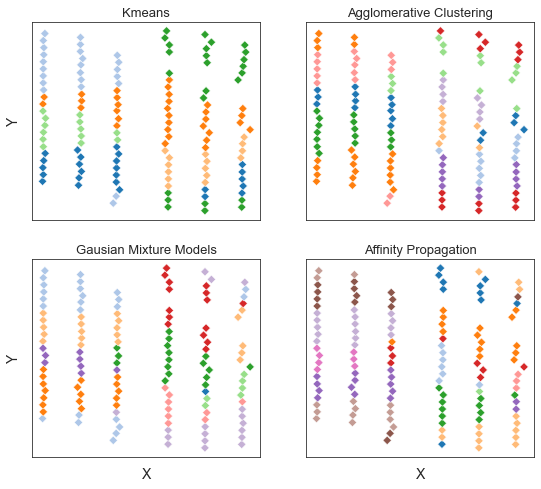

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(9, 8))
#Kmeans Approach
l = sns.scatterplot(x='x', y='y', hue='cluster_ws_kmeans', data=df_loc_clusters, palette=sns.color_palette('tab20')[:6], marker="D", ax=axes[0,0], legend=False)
l.set(xticklabels=[], yticklabels=[])
l.set_xlabel(' \n\n', fontsize=12);
l.set_title('Kmeans', fontsize=13)
l.set_ylabel('Y', fontsize=14);

#AGC Approach
m = sns.scatterplot(x='x', y='y', hue='cluster_ws_agc', data=df_loc_clusters, palette=sns.color_palette('tab20')[:10], marker="D", ax=axes[0,1], legend=False)
m.set(xticklabels=[], yticklabels=[])
m.set_xlabel(' \n\n', fontsize=12);
m.set_ylabel(' ', fontsize=14);
m.set_title('Agglomerative Clustering', fontsize=13);

#GMM Approach
n = sns.scatterplot(x='x', y='y', hue='cluster_ws_gmm', data=df_loc_clusters, palette=sns.color_palette('tab20')[:10], marker="D", ax=axes[1,0], legend=False)
n.set(xticklabels=[], yticklabels=[])
n.set_xlabel('X', fontsize=14);
n.set_ylabel('Y', fontsize=14);
n.set_title('Gausian Mixture Models', fontsize=13);

#AP Approach
p = sns.scatterplot(x='x', y='y', hue='cluster_ws_ap', data=df_loc_clusters, palette=sns.color_palette('tab20')[:13], marker="D", ax=axes[1,1], legend=False)
p.set(xticklabels=[], yticklabels=[])
p.set_xlabel('X', fontsize=14);
p.set_ylabel(' ', fontsize=12);
p.set_title('Affinity Propagation', fontsize=13);
# fig.tight_layout(h_pad=0.3)

### Test representativeness of clusters

In [70]:
%%time
# find cluster which test turbine belongs to
df_cleaned_scada_test.loc[:, 'cluster_ws_kmeans'] = df_cleaned_scada_test['TurbID'].replace(X_ws_dff.set_index('TurbID')['cluster_ws_kmeans']).values
df_cleaned_scada_test.loc[:, 'cluster_ws_agc'] = df_cleaned_scada_test['TurbID'].replace(X_ws_dff.set_index('TurbID')['cluster_ws_agc']).values
df_cleaned_scada_test.loc[:, 'cluster_ws_gmm'] = df_cleaned_scada_test['TurbID'].replace(X_ws_dff.set_index('TurbID')['cluster_ws_gmm']).values
df_cleaned_scada_test.loc[:, 'cluster_ws_ap'] = df_cleaned_scada_test['TurbID'].replace(X_ws_dff.set_index('TurbID')['cluster_ws_ap']).values

CPU times: total: 46.9 ms
Wall time: 45 ms


##### Estimation wind speed using different clustering algorithms

In [71]:
%%time
scada_merged_ws_kmeans = cleaned_scada_data.groupby(['cluster_ws_kmeans', 'date_time'], as_index=False)['Wspd'].mean()
scada_merged_ws_kmeans.columns = ['cluster_ws_kmeans', 'date_time', 'Wspd_kmeans_avg']

CPU times: total: 406 ms
Wall time: 411 ms


In [72]:
%%time
df_cleaned_scada_test['ws_kmeans_pred'] = df_cleaned_scada_test.merge(scada_merged_ws_kmeans, how='left', on=['cluster_ws_kmeans', 'date_time'])['Wspd_kmeans_avg']

CPU times: total: 62.5 ms
Wall time: 57 ms


In [73]:
%%time
scada_merged_ws_agc = cleaned_scada_data.groupby(['cluster_ws_agc', 'date_time'], as_index=False)['Wspd'].mean()
scada_merged_ws_agc.columns = ['cluster_ws_agc', 'date_time', 'Wspd_agc_avg']

CPU times: total: 391 ms
Wall time: 390 ms


In [74]:
%%time
df_cleaned_scada_test['ws_agc_pred'] = df_cleaned_scada_test.merge(scada_merged_ws_agc, how='left', on=['cluster_ws_agc', 'date_time'])['Wspd_agc_avg']

CPU times: total: 78.1 ms
Wall time: 88 ms


In [75]:
%%time
scada_merged_ws_gmm = cleaned_scada_data.groupby(['cluster_ws_gmm', 'date_time'], as_index=False)['Wspd'].mean()
scada_merged_ws_gmm.columns = ['cluster_ws_gmm', 'date_time', 'Wspd_gmm_avg']

CPU times: total: 359 ms
Wall time: 374 ms


In [76]:
%%time
df_cleaned_scada_test['ws_gmm_pred'] = df_cleaned_scada_test.merge(scada_merged_ws_gmm, how='left', on=['cluster_ws_gmm', 'date_time'])['Wspd_gmm_avg']

CPU times: total: 93.8 ms
Wall time: 94 ms


In [77]:
%%time
scada_merged_ws_ap = cleaned_scada_data.groupby(['cluster_ws_ap', 'date_time'], as_index=False)['Wspd'].mean()
scada_merged_ws_ap.columns = ['cluster_ws_ap', 'date_time', 'Wspd_ap_avg']

CPU times: total: 375 ms
Wall time: 373 ms


In [78]:
%%time
df_cleaned_scada_test['ws_ap_pred'] = df_cleaned_scada_test.merge(scada_merged_ws_ap, how='left', on=['cluster_ws_ap', 'date_time'])['Wspd_ap_avg']

CPU times: total: 109 ms
Wall time: 104 ms


##### Extract only rows with prediction of wind speed for evaluation (non-NA rows)

In [79]:
print('The Kmeans clustering method fills',round(len(df_cleaned_scada_test['ws_kmeans_pred'].dropna())/len(df_cleaned_scada_test)*100, 1),'% of original missing data')

The Kmeans clustering method fills 98.8 % of original missing data


In [80]:
print('The Agglomerative clustering method fills',round(len(df_cleaned_scada_test['ws_agc_pred'].dropna())/len(df_cleaned_scada_test)*100, 1),'% of original missing data')

The Agglomerative clustering method fills 97.1 % of original missing data


In [81]:
print('The Gaussian Mixture Model clustering method fills', round(len(df_cleaned_scada_test['ws_gmm_pred'].dropna())/len(df_cleaned_scada_test)*100, 1),'% of original missing data')

The Gaussian Mixture Model clustering method fills 96.7 % of original missing data


In [82]:
print('The Affinity Propagation clustering method fills', round(len(df_cleaned_scada_test['ws_ap_pred'].dropna())/len(df_cleaned_scada_test)*100, 1),'% of original missing data')

The Affinity Propagation clustering method fills 95.6 % of original missing data


In [83]:
df_cleaned_scada_test_ws =  df_cleaned_scada_test.dropna(subset=['ws_kmeans_pred', 'ws_agc_pred', 'ws_gmm_pred', 'ws_ap_pred'])[['TurbID', 'Day', 'Tmstamp', 'Wspd','cluster_ws_kmeans',
                                                                                                                                 'cluster_ws_agc', 'cluster_ws_gmm', 'cluster_ws_ap',
                                                                                                                                 'ws_kmeans_pred', 'ws_agc_pred', 'ws_gmm_pred', 'ws_ap_pred']]

In [130]:
round(len(df_cleaned_scada_test_ws)/len(df_cleaned_scada_test)*100, 1)

93.7

In [131]:
len(df_cleaned_scada_test_ws)

18682

#### Evaluate cluster approaches

##### RMSE

In [86]:
rmse_kmeans = mean_squared_error(df_cleaned_scada_test_ws.Wspd.values, df_cleaned_scada_test_ws.ws_kmeans_pred.values, squared=False)

In [87]:
rmse_agc = mean_squared_error(df_cleaned_scada_test_ws.Wspd.values, df_cleaned_scada_test_ws.ws_agc_pred.values, squared=False)

In [88]:
rmse_gmm = mean_squared_error(df_cleaned_scada_test_ws.Wspd.values, df_cleaned_scada_test_ws.ws_gmm_pred.values, squared=False)

In [89]:
rmse_ap = mean_squared_error(df_cleaned_scada_test_ws.Wspd.values, df_cleaned_scada_test_ws.ws_ap_pred.values, squared=False)

##### MAE

In [90]:
mae_kmeans = mean_absolute_error(df_cleaned_scada_test_ws.Wspd.values, df_cleaned_scada_test_ws.ws_kmeans_pred.values)

In [91]:
mae_agc = mean_absolute_error(df_cleaned_scada_test_ws.Wspd.values, df_cleaned_scada_test_ws.ws_agc_pred.values)

In [92]:
mae_gmm = mean_absolute_error(df_cleaned_scada_test_ws.Wspd.values, df_cleaned_scada_test_ws.ws_gmm_pred.values)

In [93]:
mae_ap = mean_absolute_error(df_cleaned_scada_test_ws.Wspd.values, df_cleaned_scada_test_ws.ws_ap_pred.values)

##### Compute MAPE metric for non-zero missing values

In [94]:
mape_kmeans = mean_absolute_percentage_error(df_cleaned_scada_test_ws[df_cleaned_scada_test_ws['Wspd'] > 0.0].Wspd.values,
                               df_cleaned_scada_test_ws[df_cleaned_scada_test_ws['Wspd'] > 0.0].ws_kmeans_pred.values)*100

In [95]:
mape_agc = mean_absolute_percentage_error(df_cleaned_scada_test_ws[df_cleaned_scada_test_ws['Wspd'] > 0.0].Wspd.values,
                               df_cleaned_scada_test_ws[df_cleaned_scada_test_ws['Wspd'] > 0.0].ws_agc_pred.values)*100

In [96]:
mape_gmm = mean_absolute_percentage_error(df_cleaned_scada_test_ws[df_cleaned_scada_test_ws['Wspd'] > 0.0].Wspd.values,
                               df_cleaned_scada_test_ws[df_cleaned_scada_test_ws['Wspd'] > 0.0].ws_gmm_pred.values)*100

In [97]:
mape_ap = mean_absolute_percentage_error(df_cleaned_scada_test_ws[df_cleaned_scada_test_ws['Wspd'] > 0.0].Wspd.values,
                               df_cleaned_scada_test_ws[df_cleaned_scada_test_ws['Wspd'] > 0.0].ws_ap_pred.values)*100

#### Visualize all metrics

In [113]:
df_rmse = pd.DataFrame(dict({'Kmeans': rmse_kmeans, 'AGC': rmse_agc, 'GMM': rmse_gmm, 'AP': rmse_ap}).items(), columns=['Method', 'RMSE'])
df_mae = pd.DataFrame(dict({'Kmeans': mae_kmeans, 'AGC': mae_agc, 'GMM': mae_gmm, 'AP': mae_ap}).items(), columns=['Method', 'MAE'])
df_mape = pd.DataFrame(dict({'Kmeans': mape_kmeans, 'AGC': mape_agc, 'GMM': mape_gmm, 'AP': mape_ap}).items(), columns=['Method', 'MAPE'])

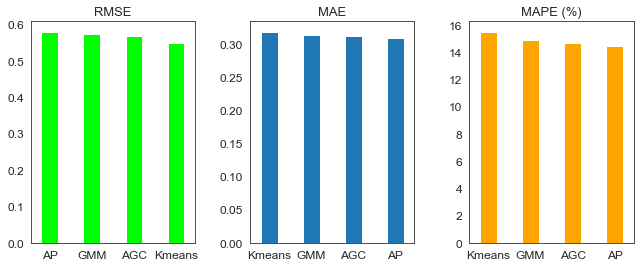

In [114]:
fig, axes = plt.subplots(1,3, figsize=(9, 4))
df_rmse.sort_values('RMSE', ascending=False).plot(x='Method', y='RMSE', kind='bar', color='lime', legend=False, ax = axes[0],  width=0.4)
axes[0].tick_params(axis='x', which='both', labelsize=12, rotation=0)
axes[0].tick_params(axis='y', which='both', labelsize=12)
axes[0].set_xlabel(' ')
axes[0].set_title('RMSE', fontsize=13);
df_mae.sort_values('MAE', ascending=False).plot(x='Method', y='MAE', kind='bar', legend=False, ax = axes[1], width=0.4)
axes[1].tick_params(axis='x', which='both', labelsize=12, rotation=0)
axes[1].tick_params(axis='y', which='both', labelsize=12)
axes[1].set_xlabel(' ')
axes[1].set_title('MAE', fontsize=13);
df_mape.sort_values('MAPE', ascending=False).plot(x='Method', y='MAPE', kind='bar', color='orange', legend=False, ax=axes[2], width=0.4);
axes[2].tick_params(axis='x', which='both', labelsize=12, rotation=0)
axes[2].tick_params(axis='y', which='both', labelsize=12)
axes[2].set_xlabel(' ')
axes[2].set_title('MAPE (%)', fontsize=13);
fig.tight_layout(w_pad=2)

##### Compute the errors

In [101]:
df_cleaned_scada_test_ws['ws_kmeans_error'] = df_cleaned_scada_test_ws['Wspd'] - df_cleaned_scada_test_ws['ws_kmeans_pred']
df_cleaned_scada_test_ws['ws_agc_error'] = df_cleaned_scada_test_ws['Wspd'] - df_cleaned_scada_test_ws['ws_agc_pred']
df_cleaned_scada_test_ws['ws_gmm_error'] = df_cleaned_scada_test_ws['Wspd'] - df_cleaned_scada_test_ws['ws_gmm_pred']
df_cleaned_scada_test_ws['ws_ap_error'] = df_cleaned_scada_test_ws['Wspd'] - df_cleaned_scada_test_ws['ws_ap_pred']

In [102]:
df_ws_errors = pd.DataFrame({'Kmeans': df_cleaned_scada_test_ws['ws_kmeans_error'].values, 'AGC': df_cleaned_scada_test_ws['ws_agc_error'].values,
                                 'GMM': df_cleaned_scada_test_ws['ws_gmm_error'].values, 'AP': df_cleaned_scada_test_ws['ws_ap_error'].values})

In [103]:
flierprops = dict(marker='.', markersize=3, markeredgecolor='g')

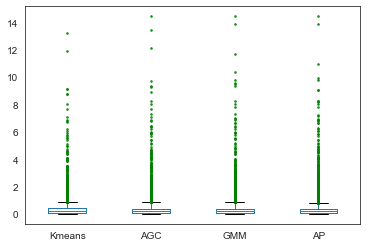

In [104]:
df_ws_errors.abs().boxplot(grid=False, flierprops=flierprops);

#### Error Distributions

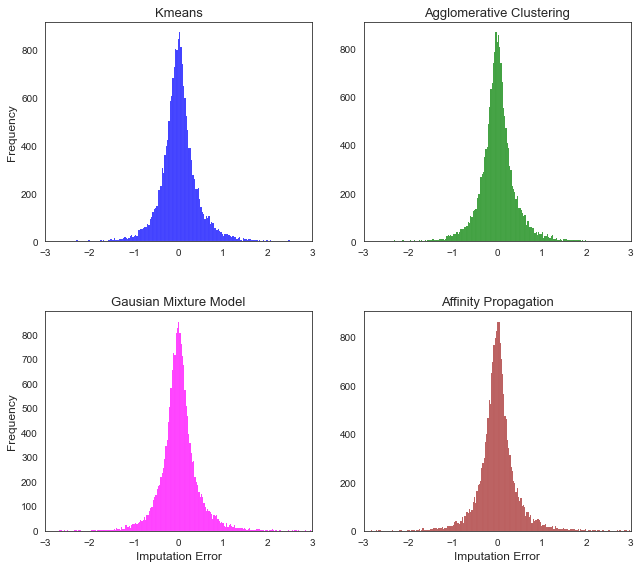

In [118]:
fig, axes = plt.subplots(2, 2, figsize=(9,8))
#Kmeans Approach
l = sns.histplot(df_cleaned_scada_test_ws['ws_kmeans_error'], color='blue', ax=axes[0,0])
l.set_xlim([-3,3])
l.set_xlabel(' \n\n', fontsize=12);
l.set_title('Kmeans', fontsize=13)
l.set_ylabel('Frequency', fontsize=12);

#AGC Approach
m = sns.histplot(df_cleaned_scada_test_ws['ws_agc_error'], color='green', ax=axes[0,1])
m.set_xlim([-3, 3]);
m.set_xlabel(' \n\n', fontsize=12);
m.set_ylabel(' ', fontsize=12);
m.set_title('Agglomerative Clustering', fontsize=13);

#GMM Approach
n = sns.histplot(df_cleaned_scada_test_ws['ws_gmm_error'], color='magenta', ax=axes[1,0])
n.set_xlim([-3, 3]);
n.set_xlabel('Imputation Error', fontsize=12);
n.set_ylabel('Frequency', fontsize=12);
n.set_title('Gausian Mixture Model', fontsize=13);

#AP Approach
p = sns.histplot(df_cleaned_scada_test_ws['ws_ap_error'], color='brown', ax=axes[1,1])
p.set_xlim([-3, 3]);
p.set_xlabel('Imputation Error', fontsize=12);
p.set_ylabel(' ', fontsize=12);
p.set_title('Affinity Propagation', fontsize=13);
fig.tight_layout(h_pad=0.1)

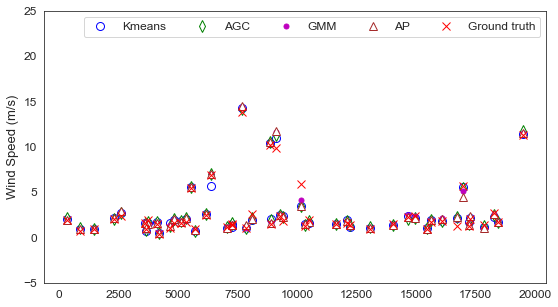

In [129]:
plt.figure(figsize=(9,5))
plt.plot(df_cleaned_scada_test_ws['ws_kmeans_pred'].sample(n=50, random_state=73), 'ob', markersize=8, mfc='white')
plt.plot(df_cleaned_scada_test_ws['ws_agc_pred'].sample(n=50, random_state=73), 'dg', mfc='white', markersize=8)
plt.plot(df_cleaned_scada_test_ws['ws_gmm_pred'].sample(n=50, random_state=73), '.m', markersize=10)
plt.plot(df_cleaned_scada_test_ws['ws_ap_pred'].sample(n=50, random_state=73), '^', color='brown', mfc='white', markersize=8)
plt.plot(df_cleaned_scada_test_ws['Wspd'].sample(n=50, random_state=73), 'xr', markersize=8)
plt.legend(labels=['Kmeans', 'AGC', 'GMM', 'AP', 'Ground truth'], fontsize=12, ncol = 5);
plt.ylabel('Wind Speed (m/s)', fontsize=13);
plt.ylim([-5, 25])
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

### Save processed data

In [106]:
# cleaned_scada_data.to_csv('cleaned_scada_data.csv', index=False)

In [686]:
# df_loc_clusters.to_csv('turbine_loc_cluster_data_all_methods_eval.csv', index=False)

In [108]:
# df_cleaned_scada_test.to_csv('missing_values_test_data.csv', index=False)

In [274]:
# df_cleaned_scada_test_ws.to_csv('ws_missing_values_results.csv')